In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import urllib3
urllib3.disable_warnings()

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ResNet 구성하기

---

### 전체적인 구조

![res](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

### plain과 residual 형태 비교

![1-1](https://github.com/JHyeok-Choi/AIFFEL/assets/119499530/33f09927-3fe8-4a42-84d4-2d6787ee2907)

### ResNet 34 와 54 의 residual 구조 차이

![1-2](https://github.com/JHyeok-Choi/AIFFEL/assets/119499530/f851976e-4760-4083-a8ef-780dc96af3c0)

### ResNet block 구성

In [3]:
# ResNet Block 함수

# Conv2D layer의 반복사용되는 부분.
def conv2d_block(x, channel, kernel_size, strides=1, name=False, add=False):
    
    x = keras.layers.Conv2D(filters=channel, kernel_size=kernel_size, activation='relu',
                            padding='same', strides=strides, name=name + '_conv')(x)
    x = keras.layers.BatchNormalization(name=name + '_bn')(x)
        
    if not add:
        x = keras.layers.Activation('relu', name=name + '_relu')(x)
    
    return x


def build_resnet_block(input_layer, num_cnn=3, channel=64, is_50=False, is_plain=False, block_num=1):
    # 입력 레이어
    x = input_layer
    a = x
    
    # CNN 레이어
    if is_50:
        for cnn_num in range(1, num_cnn+1):
            if cnn_num == 1:
                a = conv2d_block(a, channel * 4, 1, strides=2 if block_num != 2 else 1,
                                 name=f'conv{block_num}_block{cnn_num}_0', add=True)
                
            x = conv2d_block(x, channel, 1, strides=2 if block_num != 2 and cnn_num == 1 else 1,
                             name=f'conv{block_num}_block{cnn_num}_1_conv')
            x = conv2d_block(x, channel, 3, name=f'conv{block_num}_block{cnn_num}_2_conv')
            x = conv2d_block(x, channel * 4, 1, name=f'conv{block_num}_block{cnn_num}_3_conv', add=True)
            
            if not is_plain:
                x = keras.layers.Add(name=f'conv{block_num}_block{cnn_num}_add')([a, x])
            x = keras.layers.Activation('relu', name=f'conv{block_num}_block{cnn_num}_out')(x)
                
    else:
        for cnn_num in range(1, num_cnn + 1):
            if block_num >= 3 and cnn_num == 1:
                a = conv2d_block(a, channel, 1, strides=2,
                                 name=f'conv{block_num}_block{cnn_num}_0_short', add=True)
            
            x = conv2d_block(x, channel, 3, strides=2 if block_num != 2 and cnn_num == 1 else 1,
                             name=f'conv{block_num}_block{cnn_num}_1_conv')
            x = conv2d_block(x, channel, 3, name=f'conv{block_num}_block{cnn_num}_2_conv', add=True)
            
            if not is_plain:
                x = keras.layers.Add(name=f'conv{block_num}_block{cnn_num}_add')([a, x])
            x = keras.layers.Activation('relu', name=f'conv{block_num}_block{cnn_num}_out')(x)
                
        
    return x

In [4]:
# Res 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3), num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512], num_classes=10, is_50=False, is_plain=False):
    
    # 모델을 만들기 전에 config list 들이 같은 길이인지 확인합니다.
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name=f'input_layer')  # input layer를 만들어둡니다.
    
    # conv1
    output = conv2d_block(input_layer, 64, 7, strides= 2, name=f'conv1')
    
    # conv2_0 MaxPooling
    output = keras.layers.MaxPooling2D(pool_size=(2, 2), strides= 2, name=f'pool1_pool')(output)
    
    # config list 들의 길이만큼 반복해서 블록을 생성합니다.
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list), start=2):
        output = build_resnet_block(output, num_cnn=num_cnn, channel=channel, is_50=is_50, is_plain=is_plain, block_num=i)
    
    output = keras.layers.GlobalAveragePooling2D(name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

## ResNet-34

In [5]:
res_34 = build_resnet(input_shape=(32, 32, 3))
res_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

## ResNet-50

In [6]:
res_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
res_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           conv1_bn[0][0]                   
____________________________________________________________________________________________

# 일반 네트워크(plain network) 만들기

In [7]:
plainnet_34 = build_resnet(input_shape=(224, 224, 3), is_plain=True)
plainnet_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_block1_1_conv_conv (Co (None, 56, 56, 64)        36928     
_________________________________________________________________
conv2_block1_1_conv_bn (Batc (None, 56, 56, 64)        256 

In [8]:
plainnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, is_plain=True)
plainnet_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_block1_1_conv_conv (Co (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2_block1_1_conv_bn (Batc (None, 56, 56, 64)        256 

# ResNet-50 와 Plain-50 또는 ResNet-34 와 Plain-34 비교

---

## 데이터셋 준비

In [9]:
# tfds.load 사용시 cats_vs_dogs의 url이 업데이트 되지않아서 직접지정.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765")

In [10]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:25%]'],
    shuffle_files=True,
    with_info=True,
)

In [11]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: ()}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64}>

In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [14]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
train_len = int(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
test_len = int(tf.data.experimental.cardinality(ds_test))

tf.Tensor(4652, shape=(), dtype=int64)
tf.Tensor(1164, shape=(), dtype=int64)


In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
ds_info.features["label"].num_classes

2

In [18]:
ds_info.features["label"].names

['cat', 'dog']

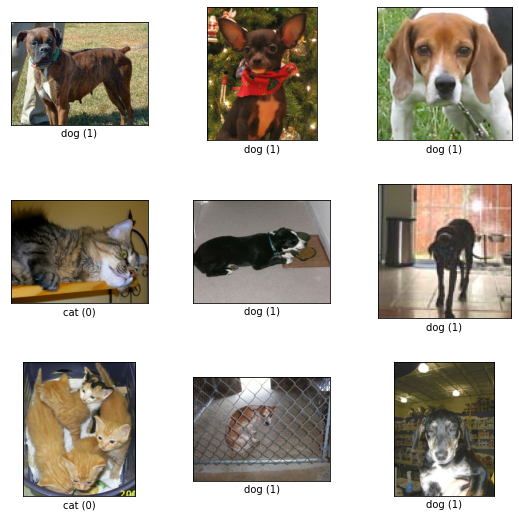

In [19]:
fig = tfds.show_examples(ds_train, ds_info)

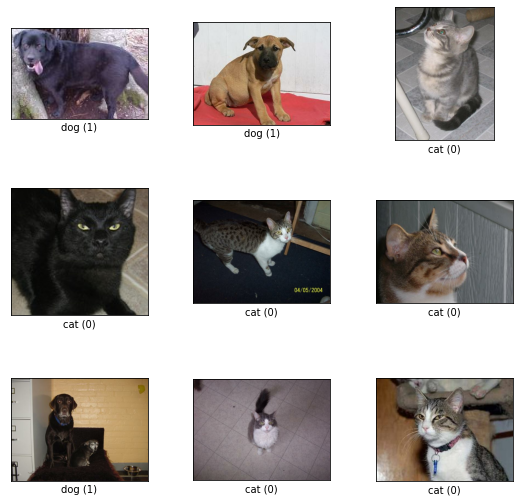

In [20]:
fig = tfds.show_examples(ds_test, ds_info)

In [21]:
BATCH_SIZE = 16
EPOCH = 10

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:25%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
ds_train

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3))

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 1s - loss: 0.8996 - accuracy: 0.5455

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 75s 130ms/step - loss: 0.8892 - accuracy: 0.5470 - val_loss: 2.1183 - val_accuracy: 0.5314
Epoch 2/10
277/290 [===========================>..] - ETA: 1s - loss: 0.6973 - accuracy: 0.5664

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 120ms/step - loss: 0.6975 - accuracy: 0.5649 - val_loss: 0.8900 - val_accuracy: 0.5130
Epoch 3/10
277/290 [===========================>..] - ETA: 1s - loss: 0.6869 - accuracy: 0.5741

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 34s 119ms/step - loss: 0.6869 - accuracy: 0.5743 - val_loss: 1.1364 - val_accuracy: 0.4965
Epoch 4/10
278/290 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 119ms/step - loss: 0.6849 - accuracy: 0.5822 - val_loss: 1.9439 - val_accuracy: 0.5166
Epoch 5/10
280/290 [===========================>..] - ETA: 1s - loss: 0.6718 - accuracy: 0.6008

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 119ms/step - loss: 0.6734 - accuracy: 0.5986 - val_loss: 0.7287 - val_accuracy: 0.5920
Epoch 6/10
280/290 [===========================>..] - ETA: 1s - loss: 0.6700 - accuracy: 0.5884

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 119ms/step - loss: 0.6711 - accuracy: 0.5875 - val_loss: 0.9377 - val_accuracy: 0.5516
Epoch 7/10
281/290 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.5951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 34s 119ms/step - loss: 0.6700 - accuracy: 0.5964 - val_loss: 1.1645 - val_accuracy: 0.5000
Epoch 8/10
283/290 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.5677

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 119ms/step - loss: 0.6808 - accuracy: 0.5695 - val_loss: 1.6039 - val_accuracy: 0.4688
Epoch 9/10
284/290 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.5885

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 34s 119ms/step - loss: 0.6772 - accuracy: 0.5878 - val_loss: 0.8158 - val_accuracy: 0.5618
Epoch 10/10
284/290 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 35s 119ms/step - loss: 0.6671 - accuracy: 0.6079 - val_loss: 0.6874 - val_accuracy: 0.5793


In [25]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 1s - loss: 1.0599 - accuracy: 0.5408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 42s 117ms/step - loss: 1.0448 - accuracy: 0.5401 - val_loss: 2.0151 - val_accuracy: 0.5000
Epoch 2/10
276/290 [===========================>..] - ETA: 1s - loss: 0.7168 - accuracy: 0.5422

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.7169 - accuracy: 0.5436 - val_loss: 0.9535 - val_accuracy: 0.4826
Epoch 3/10
278/290 [===========================>..] - ETA: 1s - loss: 0.7076 - accuracy: 0.5464

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.7071 - accuracy: 0.5459 - val_loss: 1.1028 - val_accuracy: 0.5382
Epoch 4/10
278/290 [===========================>..] - ETA: 1s - loss: 0.7030 - accuracy: 0.5567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.7035 - accuracy: 0.5539 - val_loss: 1.1655 - val_accuracy: 0.4895
Epoch 5/10
280/290 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.5587

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.6939 - accuracy: 0.5586 - val_loss: 0.8537 - val_accuracy: 0.4931
Epoch 6/10
280/290 [===========================>..] - ETA: 0s - loss: 0.6986 - accuracy: 0.5478

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.6985 - accuracy: 0.5490 - val_loss: 0.6972 - val_accuracy: 0.5627
Epoch 7/10
282/290 [============================>.] - ETA: 0s - loss: 0.6998 - accuracy: 0.5502

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.7000 - accuracy: 0.5499 - val_loss: 0.7824 - val_accuracy: 0.5653
Epoch 8/10
283/290 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.5411

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.6987 - accuracy: 0.5418 - val_loss: 0.7804 - val_accuracy: 0.4895
Epoch 9/10
283/290 [============================>.] - ETA: 0s - loss: 0.6974 - accuracy: 0.5506

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.6972 - accuracy: 0.5500 - val_loss: 1.3450 - val_accuracy: 0.5497
Epoch 10/10
285/290 [============================>.] - ETA: 0s - loss: 0.6904 - accuracy: 0.5601

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 33s 115ms/step - loss: 0.6906 - accuracy: 0.5589 - val_loss: 0.7403 - val_accuracy: 0.5218


In [26]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(train_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 2s - loss: 0.8933 - accuracy: 0.5374

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 83s 245ms/step - loss: 0.8851 - accuracy: 0.5399 - val_loss: 2.1351 - val_accuracy: 0.4838
Epoch 2/10
276/290 [===========================>..] - ETA: 2s - loss: 0.7172 - accuracy: 0.5555

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 71s 244ms/step - loss: 0.7162 - accuracy: 0.5567 - val_loss: 0.7675 - val_accuracy: 0.4918
Epoch 3/10
277/290 [===========================>..] - ETA: 2s - loss: 0.7016 - accuracy: 0.5707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 243ms/step - loss: 0.7024 - accuracy: 0.5673 - val_loss: 1.1249 - val_accuracy: 0.5106
Epoch 4/10
277/290 [===========================>..] - ETA: 2s - loss: 0.6905 - accuracy: 0.5759

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6905 - accuracy: 0.5753 - val_loss: 1.7559 - val_accuracy: 0.5303
Epoch 5/10
279/290 [===========================>..] - ETA: 2s - loss: 0.6855 - accuracy: 0.5848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6855 - accuracy: 0.5858 - val_loss: 0.7267 - val_accuracy: 0.5534
Epoch 6/10
279/290 [===========================>..] - ETA: 2s - loss: 0.6722 - accuracy: 0.5997

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6733 - accuracy: 0.5994 - val_loss: 1.2208 - val_accuracy: 0.5357
Epoch 7/10
280/290 [===========================>..] - ETA: 1s - loss: 0.6881 - accuracy: 0.5775

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6880 - accuracy: 0.5774 - val_loss: 1.5321 - val_accuracy: 0.5197
Epoch 8/10
281/290 [============================>.] - ETA: 1s - loss: 0.6771 - accuracy: 0.6020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6763 - accuracy: 0.6032 - val_loss: 1.1188 - val_accuracy: 0.5169
Epoch 9/10
282/290 [============================>.] - ETA: 1s - loss: 0.6813 - accuracy: 0.5874

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6829 - accuracy: 0.5856 - val_loss: 0.7194 - val_accuracy: 0.5478
Epoch 10/10
283/290 [============================>.] - ETA: 1s - loss: 0.6723 - accuracy: 0.5917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 70s 242ms/step - loss: 0.6728 - accuracy: 0.5917 - val_loss: 3.4850 - val_accuracy: 0.5227


In [27]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_len/BATCH_SIZE),
    validation_steps=int(test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


275/290 [===========================>..] - ETA: 2s - loss: 1.1616 - accuracy: 0.5182

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 61s 176ms/step - loss: 1.1385 - accuracy: 0.5226 - val_loss: 1.9613 - val_accuracy: 0.4948
Epoch 2/10
275/290 [===========================>..] - ETA: 2s - loss: 0.7183 - accuracy: 0.5246

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 172ms/step - loss: 0.7175 - accuracy: 0.5255 - val_loss: 1.8205 - val_accuracy: 0.4956
Epoch 3/10
277/290 [===========================>..] - ETA: 1s - loss: 0.7066 - accuracy: 0.5478

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 173ms/step - loss: 0.7073 - accuracy: 0.5470 - val_loss: 0.8507 - val_accuracy: 0.5409
Epoch 4/10
277/290 [===========================>..] - ETA: 1s - loss: 0.7015 - accuracy: 0.5434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 172ms/step - loss: 0.7011 - accuracy: 0.5447 - val_loss: 0.7886 - val_accuracy: 0.5408
Epoch 5/10
278/290 [===========================>..] - ETA: 1s - loss: 0.7052 - accuracy: 0.5418

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 172ms/step - loss: 0.7051 - accuracy: 0.5401 - val_loss: 0.7280 - val_accuracy: 0.5139
Epoch 6/10
280/290 [===========================>..] - ETA: 1s - loss: 0.7050 - accuracy: 0.5335

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 172ms/step - loss: 0.7043 - accuracy: 0.5341 - val_loss: 0.8483 - val_accuracy: 0.5726
Epoch 7/10
281/290 [============================>.] - ETA: 1s - loss: 0.7101 - accuracy: 0.5272

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 173ms/step - loss: 0.7106 - accuracy: 0.5265 - val_loss: 0.7225 - val_accuracy: 0.5174
Epoch 8/10
282/290 [============================>.] - ETA: 1s - loss: 0.7036 - accuracy: 0.5393

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 173ms/step - loss: 0.7032 - accuracy: 0.5399 - val_loss: 0.8247 - val_accuracy: 0.5113
Epoch 9/10
283/290 [============================>.] - ETA: 1s - loss: 0.7033 - accuracy: 0.5287

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 173ms/step - loss: 0.7035 - accuracy: 0.5291 - val_loss: 1.3043 - val_accuracy: 0.5253
Epoch 10/10
284/290 [============================>.] - ETA: 0s - loss: 0.7054 - accuracy: 0.5251

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - 50s 173ms/step - loss: 0.7056 - accuracy: 0.5254 - val_loss: 1.3670 - val_accuracy: 0.4939


## 시각화

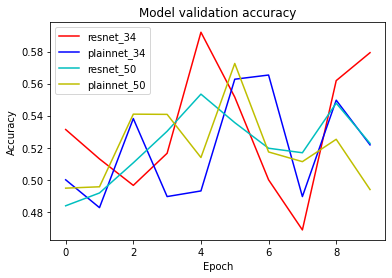

In [30]:
plt.plot(history_res_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_res_50.history['val_accuracy'], 'c')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34', 'resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

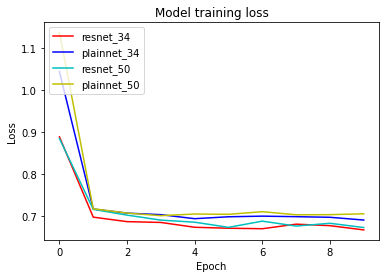

In [31]:
plt.plot(history_res_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.plot(history_res_50.history['loss'], 'c')
plt.plot(history_plain_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34', 'resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

|model|Loss|Accuracy|
|:----|:---:|:---:|
|res_34|0.6671|0.5793|
|plain_34|0.6906|0.5218|
|res_50|0.6728|0.5227|
|plain_50|0.7056|0.4939|

# 회고

* ResNet의 residual 유무의 차이에 따른 성능차이를 확인해보는 프로젝트입니다.
* ResNet을 구현하는데 논문과 tensorflow.keras.layers 들의 정보만보고 구현해보면서 모델구조와 각 레이어들의 이해가 더욱 깊어지는 좋은 시간이었습니다.
* 훈련중 메모리가 부족한지 학습이 진행되다 말아서 데이터를 줄이고, epoch를 낮게 설정해서 테스트해보았지만, ResNet이 PlainNet보다 성능이 좋은것은 확인되었습니다.
* 하지만 논문에서와는 다르게 ResNet50과 PlainNet_50의 성능이 34보다 낮은것은 의아합니다, 어떤 부분이 문제였는지 좀 더 생각해봐야 할것같습니다.